# Normalizing Flows: Planar Flows and Radial Flows
This jupyter notebook shows the effect of planar and radial flows on a multivariate normal distribution.
The parameters of the flows can be adjusted manually and the function f(z) can be applied in several iterations.
For the theory about normalizing flows, in particular planar and radial flows, have a look at this blog post: http://akosiorek.github.io/ml/2018/04/03/norm_flows.html

## 1. Load input data

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from scipy.stats import multivariate_normal

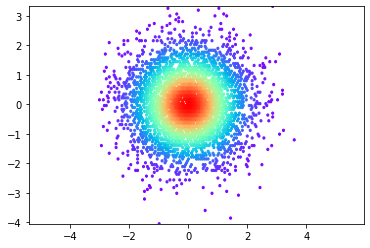

In [23]:
# define and draw samples from a multivariate normal distribution as input z
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # unit covariance
mvn = multivariate_normal(mean=mean, cov=cov)
z1, z2 = np.random.multivariate_normal(mean, cov, 5000).T
z = np.array([z1, z2]).T
p_z =mvn.pdf(z)
plt.hexbin(z[:,0], z[:,1], C=p_z, cmap='rainbow')
plt.axis('equal')
plt.show()

## 2. Planar Flows
$f(\mathbf{z})=\mathbf{z}+\mathbf{u} h\left(\mathbf{w}^{T} \mathbf{z}+b\right)$

with $\mathbf{u}, \mathbf{w} \in \mathbb{R}^{d}$ and $b \in \mathbb{R}$ and $h$ an element-wise non-linearity.

To calculate $p(x)$ we use sampling with the Jacobian:

$\frac{\partial f(\mathbf{z})}{\partial \mathbf{z}}=\mathbf{I}+\mathbf{u} h^{\prime}\left(\mathbf{w}^{\top} \mathbf{z}+b\right) \mathbf{w}^{\top}$

The determinant of the Jacobian is defined as:

$\begin{aligned} \operatorname{det} \frac{\partial f(\mathbf{z})}{\partial \mathbf{z}} &=\left(1+h^{\prime}\left(\mathbf{w}^{\top} \mathbf{z}+b\right) \mathbf{w}^{\top} \mathbf{I}^{-1} \mathbf{u}\right) \operatorname{det}(\mathbf{I}) \\ &=\left(1+h^{\prime}\left(\mathbf{w}^{\top} \mathbf{z}+b\right) \mathbf{w}^{\top} \mathbf{u}\right) \end{aligned}$

Note that this notebook just shows the effect planar and radial flows on the input data. Usually, the parameters w, u, and b are trainable. However, in this notebook we keep them fix.

In [35]:
# define different w, u, and b of function f(z)
w1 = np.array([5, 1])
w2 = np.array([5, 5])
w = [w1, w2]
u1 = np.array([5, 1])
u2 = np.array([5, 5])
u = [u1, u2]
b1 = 0
b2 = 10
b = [b1, b2]
# define how often the planar flow should be applied
k = 1

In [25]:
# define function h, usually tanh(x)
def h_planar(x):
    return np.tanh(x)

In [26]:
# derivative of h = tanh(x)
def h_planar_prime(x):
    return 1 - np.tanh(x) ** 2

In [27]:
# define function f(z) for planar flow
def f_planar(z, w, u, b):
    y = z + np.dot(h_planar(np.dot(z, w) + b).reshape(-1,1), u.reshape(1,-1))
    return y

In [28]:
# define the determinant of the Jacobian
def det_J_planar(z, w, u, b):
    psi = h_planar_prime(np.dot(z, w) + b).reshape(-1,1) * w
    det = np.abs(1 + np.dot(psi, u.reshape(-1,1)))
    return det

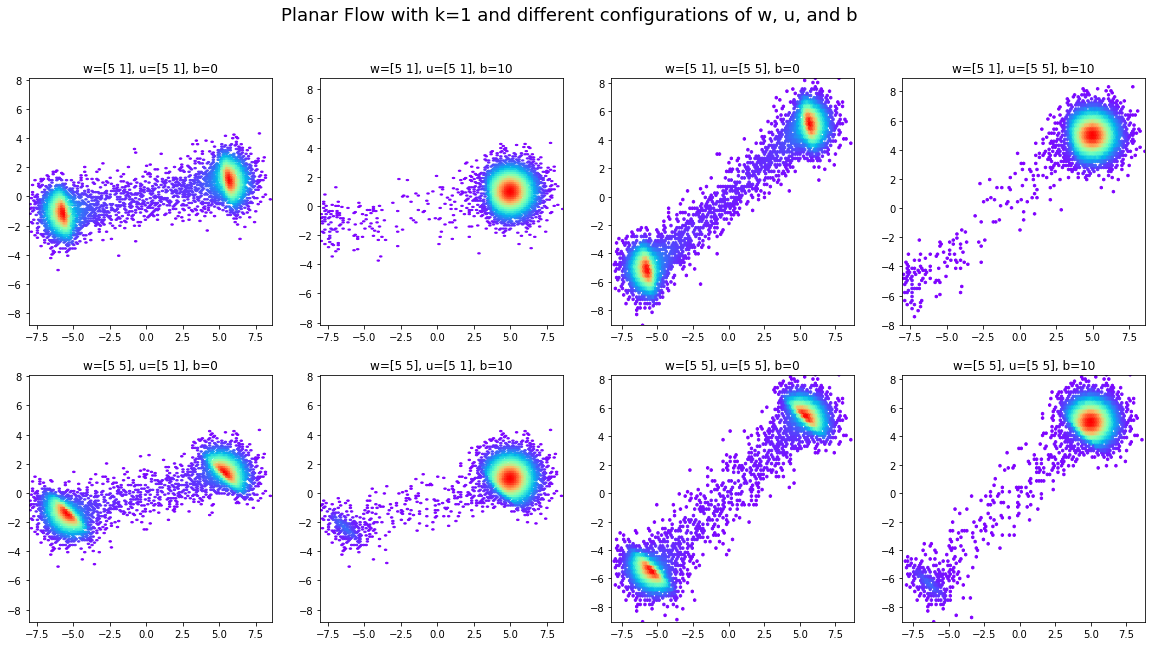

In [37]:
# create a plot for 8 different configurations of w, u, and b
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(20, 10)
fig.suptitle(f"Planar Flow with k={k} and different configurations of w, u, and b", fontsize=18)
row = 0
column = 0
# loop through the different configurations
x = z
for w_i in w:
    for u_i in u:
        for b_i in b:
            # apply f(z) k times
            det = 1
            for i in range(k):
                x = f_planar(x, w_i, u_i, b_i)
                det = det * 1/det_J_planar(z, w_i, u_i, b_i).squeeze()
            p_x = p_z.squeeze()*det.squeeze()
            # plot samples
            # axs[row, column].plot(x[:,0], x[:,1], "x")
            axs[row, column].hexbin(x[:,0], x[:,1], C=p_x, cmap='rainbow')
            axs[row, column].axis('equal')
            axs[row, column].set_title(f"w={w_i}, u={u_i}, b={b_i}")
            column = column + 1
            if column == 4:
                column = 0
            # reset x after each plot
            x = z
    row = row + 1
    
fig.savefig("Planar Flow.png",format="png")



### Interpretation
Looking at the plots above, we can imagine a planar flow as a straight hyperplane, where each line contracts or expands the space around it.

## 3. Radial Flows
$f(\mathbf{z})=\mathbf{z}+\beta h(\alpha, r)\left(\mathbf{z}-\mathbf{z}_{0}\right)$

with $r=\left\|\mathbf{z}-\mathbf{z}_{0}\right\|_{2}, h(\alpha, r)=\frac{1}{\alpha+r}$ and parameters $\mathbf{z}_{0} \in \mathbb{R}^{d}, \alpha \in \mathbb{R}_{+}$ and $\beta \in \mathbb{R}$.
Usually, parameters $\mathbf{z}_0$, $\alpha$ and $\beta$ are learnable parameters.

To calculate p(x) we use again sampling with the Jacobian:
$\begin{aligned} \frac{\partial f(\mathbf{z})}{\partial \mathbf{z}} &=\mathbf{I}+\beta\left(\left(\mathbf{z}-\mathbf{z}_{0}\right) h^{\prime}(\alpha, r) \frac{\partial r}{\partial \mathbf{z}}+h(\alpha, r) \mathbf{I}\right) \\ &=(1+\beta h(\alpha, r)) \mathbf{I}+\beta h^{\prime}(\alpha, r)\left(\mathbf{z}-\mathbf{z}_{0}\right) \frac{\left(\mathbf{z}-\mathbf{z}_{0}\right)^{\top}}{\left\|\mathbf{z}-\mathbf{z}_{0}\right\|} \end{aligned}$

With $\gamma=(1+\beta h(\alpha, r))$ the determinant of the Jacobian can be computed as:

$\begin{aligned} \operatorname{det} \frac{\partial f(\mathbf{z})}{\partial \mathbf{z}} &=\left(1+\beta h^{\prime}(\alpha, r) \frac{\left(\mathbf{z}-\mathbf{z}_{0}\right)^{\top}}{\left\|\mathbf{z}-\mathbf{z}_{0}\right\|} \frac{\mathbf{I}}{\gamma}\left(\mathbf{z}-\mathbf{z}_{0}\right)\right) \operatorname{det}(\gamma \mathbf{I}) \\ &=\left(\frac{1+\beta h(\alpha, r)+\beta h^{\prime}(\alpha, r)\left\|\mathbf{z}-\mathbf{z}_{0}\right\|}{(1+\beta h(\alpha, r))}\right)(1+\beta h(\alpha, r))^{d} \\ &=\left(1+\beta h(\alpha, r)+\beta h^{\prime}(\alpha, r) r\right)(1+\beta h(\alpha, r))^{d-1} \end{aligned}$

In [46]:
# define different parameters z0, alpha (a), and beta (b)
z0_1 = np.array([2, 2])
z0_2 = np.array([4, 0])
z0 = [z0_1, z0_2]
a1 = 1
a2 = 5
a = [a1, a2]
b1 = 5
b2 = 10
b = [b1, b2]
# define how often the planar flow should be applied
k = 1

In [39]:
# define function h(a,r)
def h_radial(a,r):
    return 1/(a+r)

In [40]:
# derivative of h(a,r)
def h_radial_prime(a,r):
    return -1/(a+r) ** 2

In [41]:
# define function f(z) for radial flow
def f_radial(z, z0, a, b):
    r = LA.norm(z - z0, axis=1).reshape(-1, 1)
    y = z + b * h_radial(a,r) * (z - z0)
    return y

In [42]:
# define the determinant of the Jacobian det()
def det_J_radial(z, z0, a, b):
    n_dims = z.shape[1]
    r = LA.norm(z - z0, axis=1).reshape(-1, 1)
    tmp = 1 + b * h_radial(a,r)
    det = (tmp + b * h_radial_prime(a,r) * r) * tmp ** (n_dims - 1)
    return det

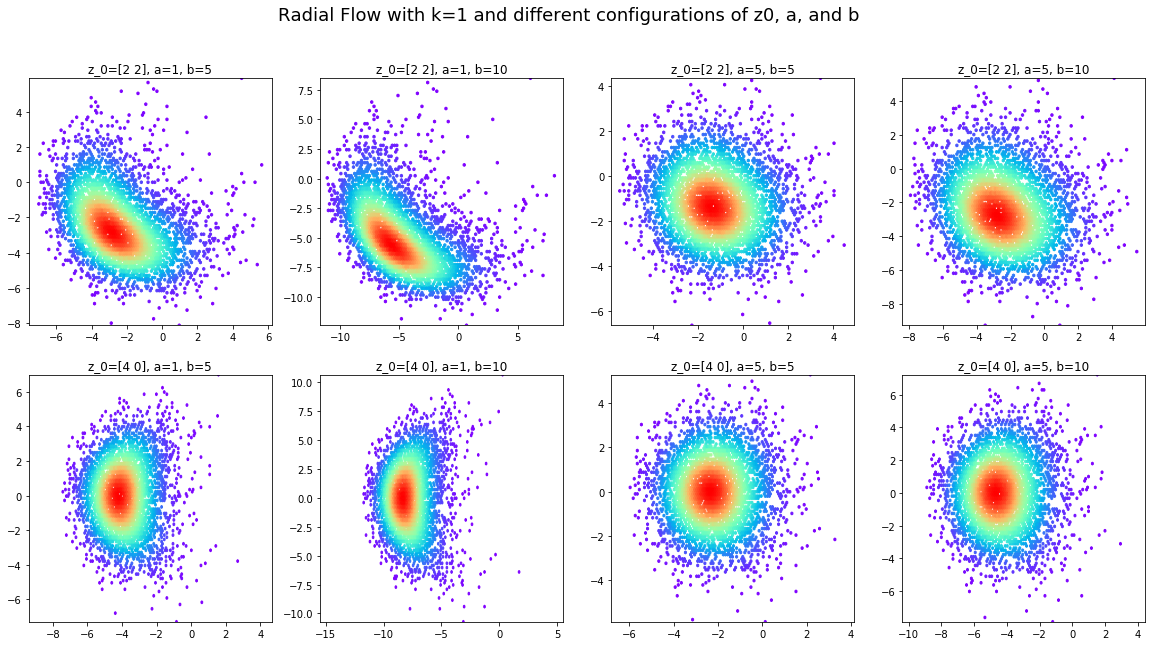

In [47]:
# create a plot for 8 different configurations of z0, a, and b
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(20, 10)
fig.suptitle(f"Radial Flow with k={k} and different configurations of z0, a, and b", fontsize=18)
row = 0
column = 0
# loop through the different configurations
x = z
for z0_i in z0:
    for a_i in a:
        for b_i in b:
            # apply f(z) k times
            det = 1
            for i in range(k):
                x = f_radial(x, z0_i, a_i, b_i)
                det = det * 1/det_J_radial(z, z0_i, a_i, b_i).squeeze()
            p_x = p_z.squeeze()*det.squeeze()
            # plot samples
            # axs[row, column].plot(x[:,0], x[:,1], "x")
            axs[row, column].hexbin(x[:,0], x[:,1], C=p_x, cmap='rainbow')
            axs[row, column].axis('equal')
            axs[row, column].set_title(f"z_0={z0_i}, a={a_i}, b={b_i}")
            column = column + 1
            if column == 4:
                column = 0
            # reset x after each plot
            x = z
    row = row + 1
                       
fig.savefig("Radial Flow.png",format="png")

### Interpretation
We can imagine radial flows as spheres in the z-space that either contract or expand the space inside the sphere (similar to hyperplanes for planar flows).